In [83]:
import numpy as np
from tensorflow.keras import layers, models
import tensorflow as tf

In [84]:
import pandas as pd
from src.utils.path_utils import get_raw_data_dir

# Build the file path for the processed data file.
path = str(get_raw_data_dir()) + "/S3M6F1O1_dataset.csv"

# Load the data file
data = pd.read_csv(path)

In [121]:
# Get X data and y data
y_data = data['label'].values
X_data = data.drop(columns=['label']).values

# Transform to numpy array
X_data = np.array(X_data)
y_data = np.array(y_data)

# Determine the number of unique classes in the labels.
num_classes = data['label'].nunique()

In [126]:
input_shape = X_data.shape[1]
input_shape

1000

In [127]:
num_classes

3

In [192]:
def stft_layer(x):
    # x shape: (batch, time)
    stft = tf.signal.stft(x, frame_length=128, frame_step=64)
    spectrogram = tf.abs(stft)
    return spectrogram

In [193]:
input_layer = layers.Input(shape=(input_shape,))
x = layers.Lambda(stft_layer, name='stft')(input_layer)

In [194]:
# Assume input_layer and x (after Lambda) are already defined as in your model
stft_model = models.Model(inputs=input_layer, outputs=x)  # x is the output of the Lambda layer

In [195]:
# Pass a sample or batch through the STFT layer
sample_output = stft_model.predict(X_data[:1])  # Use one or more samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [196]:
print("STFT output shape:", sample_output.shape)

STFT output shape: (1, 14, 65)


In [197]:
input_layer.shape

(None, 1000)

In [198]:
x.shape

(None, 14, 65)

In [199]:
print("STFT output (magnitude spectrogram):", sample_output)

STFT output (magnitude spectrogram): [[[8.66903076e+01 4.33704681e+01 6.84109032e-02 7.24421740e-02
   4.10011001e-02 2.46561002e-02 1.38262361e-02 5.97371832e-02
   1.19603537e-01 6.19143918e-02 3.10535729e-02 1.58816874e-02
   1.97616871e-02 2.39453986e-02 2.12151576e-02 1.14373174e-02
   1.11407517e-02 3.07864137e-03 1.00435149e-02 1.52037237e-02
   1.34151299e-02 1.37920622e-02 1.01258280e-02 5.23528922e-03
   6.54907618e-03 1.31657273e-02 8.17346200e-03 1.21043380e-02
   2.56233625e-02 3.30508277e-02 3.04095596e-02 2.16336660e-02
   1.58868097e-02 1.27626779e-02 2.74271052e-03 4.23489558e-03
   1.93822687e-03 5.09903207e-03 1.10794324e-02 1.22600179e-02
   8.15089792e-03 6.11557392e-03 6.36252947e-03 1.11242430e-02
   1.42403571e-02 1.34727564e-02 1.36939883e-02 9.52583645e-03
   3.10837128e-03 7.65523454e-03 1.09283645e-02 2.85800477e-03
   6.69275364e-03 5.10146935e-03 5.58202155e-03 8.68526474e-03
   1.47687467e-02 1.50288912e-02 7.27667054e-03 5.35541354e-03
   2.39193626e-03 

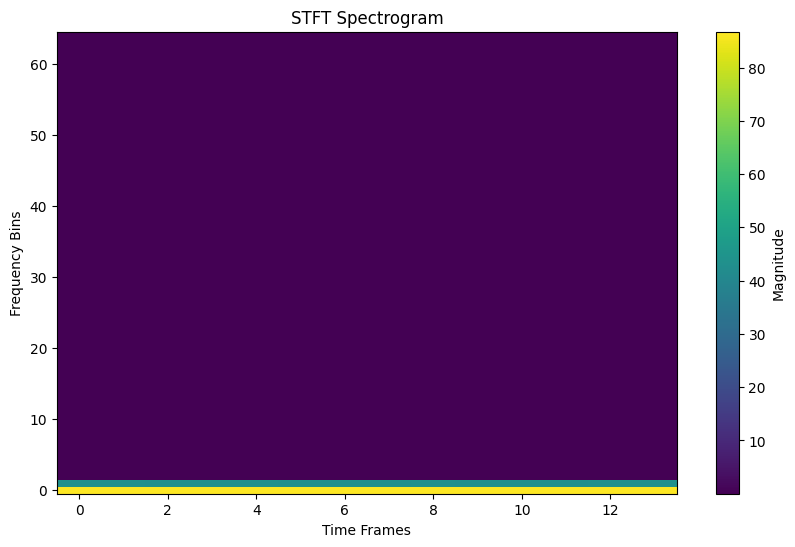

In [208]:
import matplotlib.pyplot as plt

# Visualize the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(sample_output[0].T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('STFT Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.show()

In [201]:
input_layer = layers.Input(shape=(input_shape,))
x = layers.Lambda(stft_layer, name='stft')(input_layer)
x = layers.Reshape((1, -1))(x)
x = layers.Dense(32, activation='tanh')(x)
x = layers.LSTM(64, unroll=True, activation='tanh')(x)
x = layers.Dense(32, activation='tanh')(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

In [202]:
LSTM_model = models.Model(inputs=input_layer, outputs=output_layer)

In [203]:
LSTM_model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [204]:
LSTM_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stft (Lambda)                   │ (None, 14, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 1, 910)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1, 32)          │        29,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,163 (219.39 KB)

 Trainable params: 56,163 (219.39 KB)

 Non-trainable params: 0 (0.00 B)

In [205]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% validation sets.
X_train, X_val, y_train, y_val = train_test_split(
        X_data, y_data, test_size=0.2
)

In [206]:
X_train.shape

(873, 1000)

In [207]:
LSTM_model.fit(X_train, y_train,
       validation_data=(X_val, y_val),
       epochs=5,
       batch_size=32)

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3972 - loss: 1.0582 - val_accuracy: 0.4475 - val_loss: 1.0017
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4376 - loss: 1.0433 - val_accuracy: 0.4475 - val_loss: 0.9983
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4800 - loss: 1.0148 - val_accuracy: 0.4475 - val_loss: 0.9995
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4711 - loss: 1.0299 - val_accuracy: 0.4475 - val_loss: 0.9940
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4590 - loss: 1.0275 - val_accuracy: 0.4475 - val_loss: 0.9989
